In [ ]:
#!pip install --upgrade numpy

In [ ]:
#!pip install numpy==1.23.5

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

import scipy
from scipy.stats import chi2
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr, spearmanr

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import export_graphviz
from six import StringIO
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, auc, roc_curve
# from category_encoders.binary import BinaryEncoder
from IPython.display import Image
import pydotplus

import matplotlib.pyplot as plt
%matplotlib inline
color = sns.color_palette()

seed = 42

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Project_Data/lending_club_loan_dataset.csv', low_memory = False)

In [ ]:
data.head()

,id,grade,annual_inc,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,od_ratio,bad_loan
0,11454641,A,100000.0,1,1,RENT,26.27,credit_card,36 months,1,NaN,43.2,0.0,0.160624,0
1,9604874,A,83000.0,0,4,OWN,5.39,credit_card,36 months,0,NaN,21.5,0.0,0.810777,0
2,9684700,D,78000.0,0,11,MORTGAGE,18.45,debt_consolidation,60 months,1,NaN,46.3,0.0,0.035147,1
3,9695736,D,37536.0,0,6,MORTGAGE,12.28,medical,60 months,0,NaN,10.7,0.0,0.534887,1
4,9795013,D,65000.0,0,11,MORTGAGE,11.26,debt_consolidation,36 months,0,NaN,15.2,0.0,0.166500,0


In [ ]:
data.shape

(20000, 15)

In [ ]:
data.describe()

,id,annual_inc,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,od_ratio,bad_loan
count,2.000000e+04,20000.000000,20000.000000,20000.00000,19846.000000,20000.000000,574.000000,20000.000000,20000.000000,20000.000000,20000.00000
mean,7.590662e+06,73349.578350,0.112500,6.82140,16.587841,0.546600,0.759582,55.958148,0.290622,0.504430,0.20000
std,1.609593e+06,45198.567255,0.315989,3.77423,7.585812,0.497836,0.427710,42.117456,3.108654,0.287720,0.40001
min,5.860400e+05,8412.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000077,0.00000
25%,6.206283e+06,47000.000000,0.000000,3.00000,10.852500,0.000000,1.000000,38.800000,0.000000,0.257356,0.00000
50%,7.378896e+06,65000.000000,0.000000,7.00000,16.190000,1.000000,1.000000,57.100000,0.000000,0.506681,0.00000
75%,8.766235e+06,88000.000000,0.000000,11.00000,22.060000,1.000000,1.000000,73.900000,0.000000,0.753771,0.00000
max,1.145464e+07,1000000.000000,1.000000,11.00000,34.990000,1.000000,1.000000,5010.000000,96.466600,0.999894,1.00000


In [ ]:
data.dtypes

,0
id,int64
grade,object
annual_inc,float64
short_emp,int64
emp_length_num,int64
home_ownership,object
dti,float64
purpose,object
term,object
last_delinq_none,int64


In [ ]:
data.isnull().mean() * 100

,0
id,0.000
grade,0.000
annual_inc,0.000
short_emp,0.000
emp_length_num,0.000
home_ownership,7.455
dti,0.770
purpose,0.000
term,0.000
last_delinq_none,0.000


In [ ]:
data.drop(['last_major_derog_none'], axis = 1, inplace = True)

In [ ]:
num_cols = data.select_dtypes(include = 'number')
print(list(num_cols))
print(list(set(data.columns) - set(num_cols)))

['id', 'annual_inc', 'short_emp', 'emp_length_num', 'dti', 'last_delinq_none', 'revol_util', 'total_rec_late_fee', 'od_ratio', 'bad_loan']
['grade', 'purpose', 'term', 'home_ownership']


In [ ]:
data.describe(include = [object])

,grade,home_ownership,purpose,term
count,20000,18509,20000,20000
unique,7,3,12,3
top,B,MORTGAGE,debt_consolidation,36 months
freq,6042,9844,12337,14969


In [ ]:
data.bad_loan.value_counts()/data.bad_loan.value_counts().sum()*100

,count
bad_loan,
0,80.0
1,20.0


In [ ]:
def target(x):
    short_0 = data[data.bad_loan == 0].loc[:,x]
    short_1 = data[data.bad_loan == 1].loc[:,x]

    a = np.array(short_0)
    b = np.array(short_1)

    np.warnings.filterwarnings('ignore')
    plt.figure(figsize=(20, 5))

    plt.hist(a, bins=40, density=True, color="g", alpha = 0.6, label='Not-default', align="left")
    plt.hist(b, bins=40, density=True, color="r", alpha = 0.6, label='Default', align="right")
    plt.legend(loc='upper right')
    plt.title(x, fontsize=10, loc="right")
    plt.xlabel('Relative frequency')
    plt.ylabel('Absolute frequency')
    plt.show()





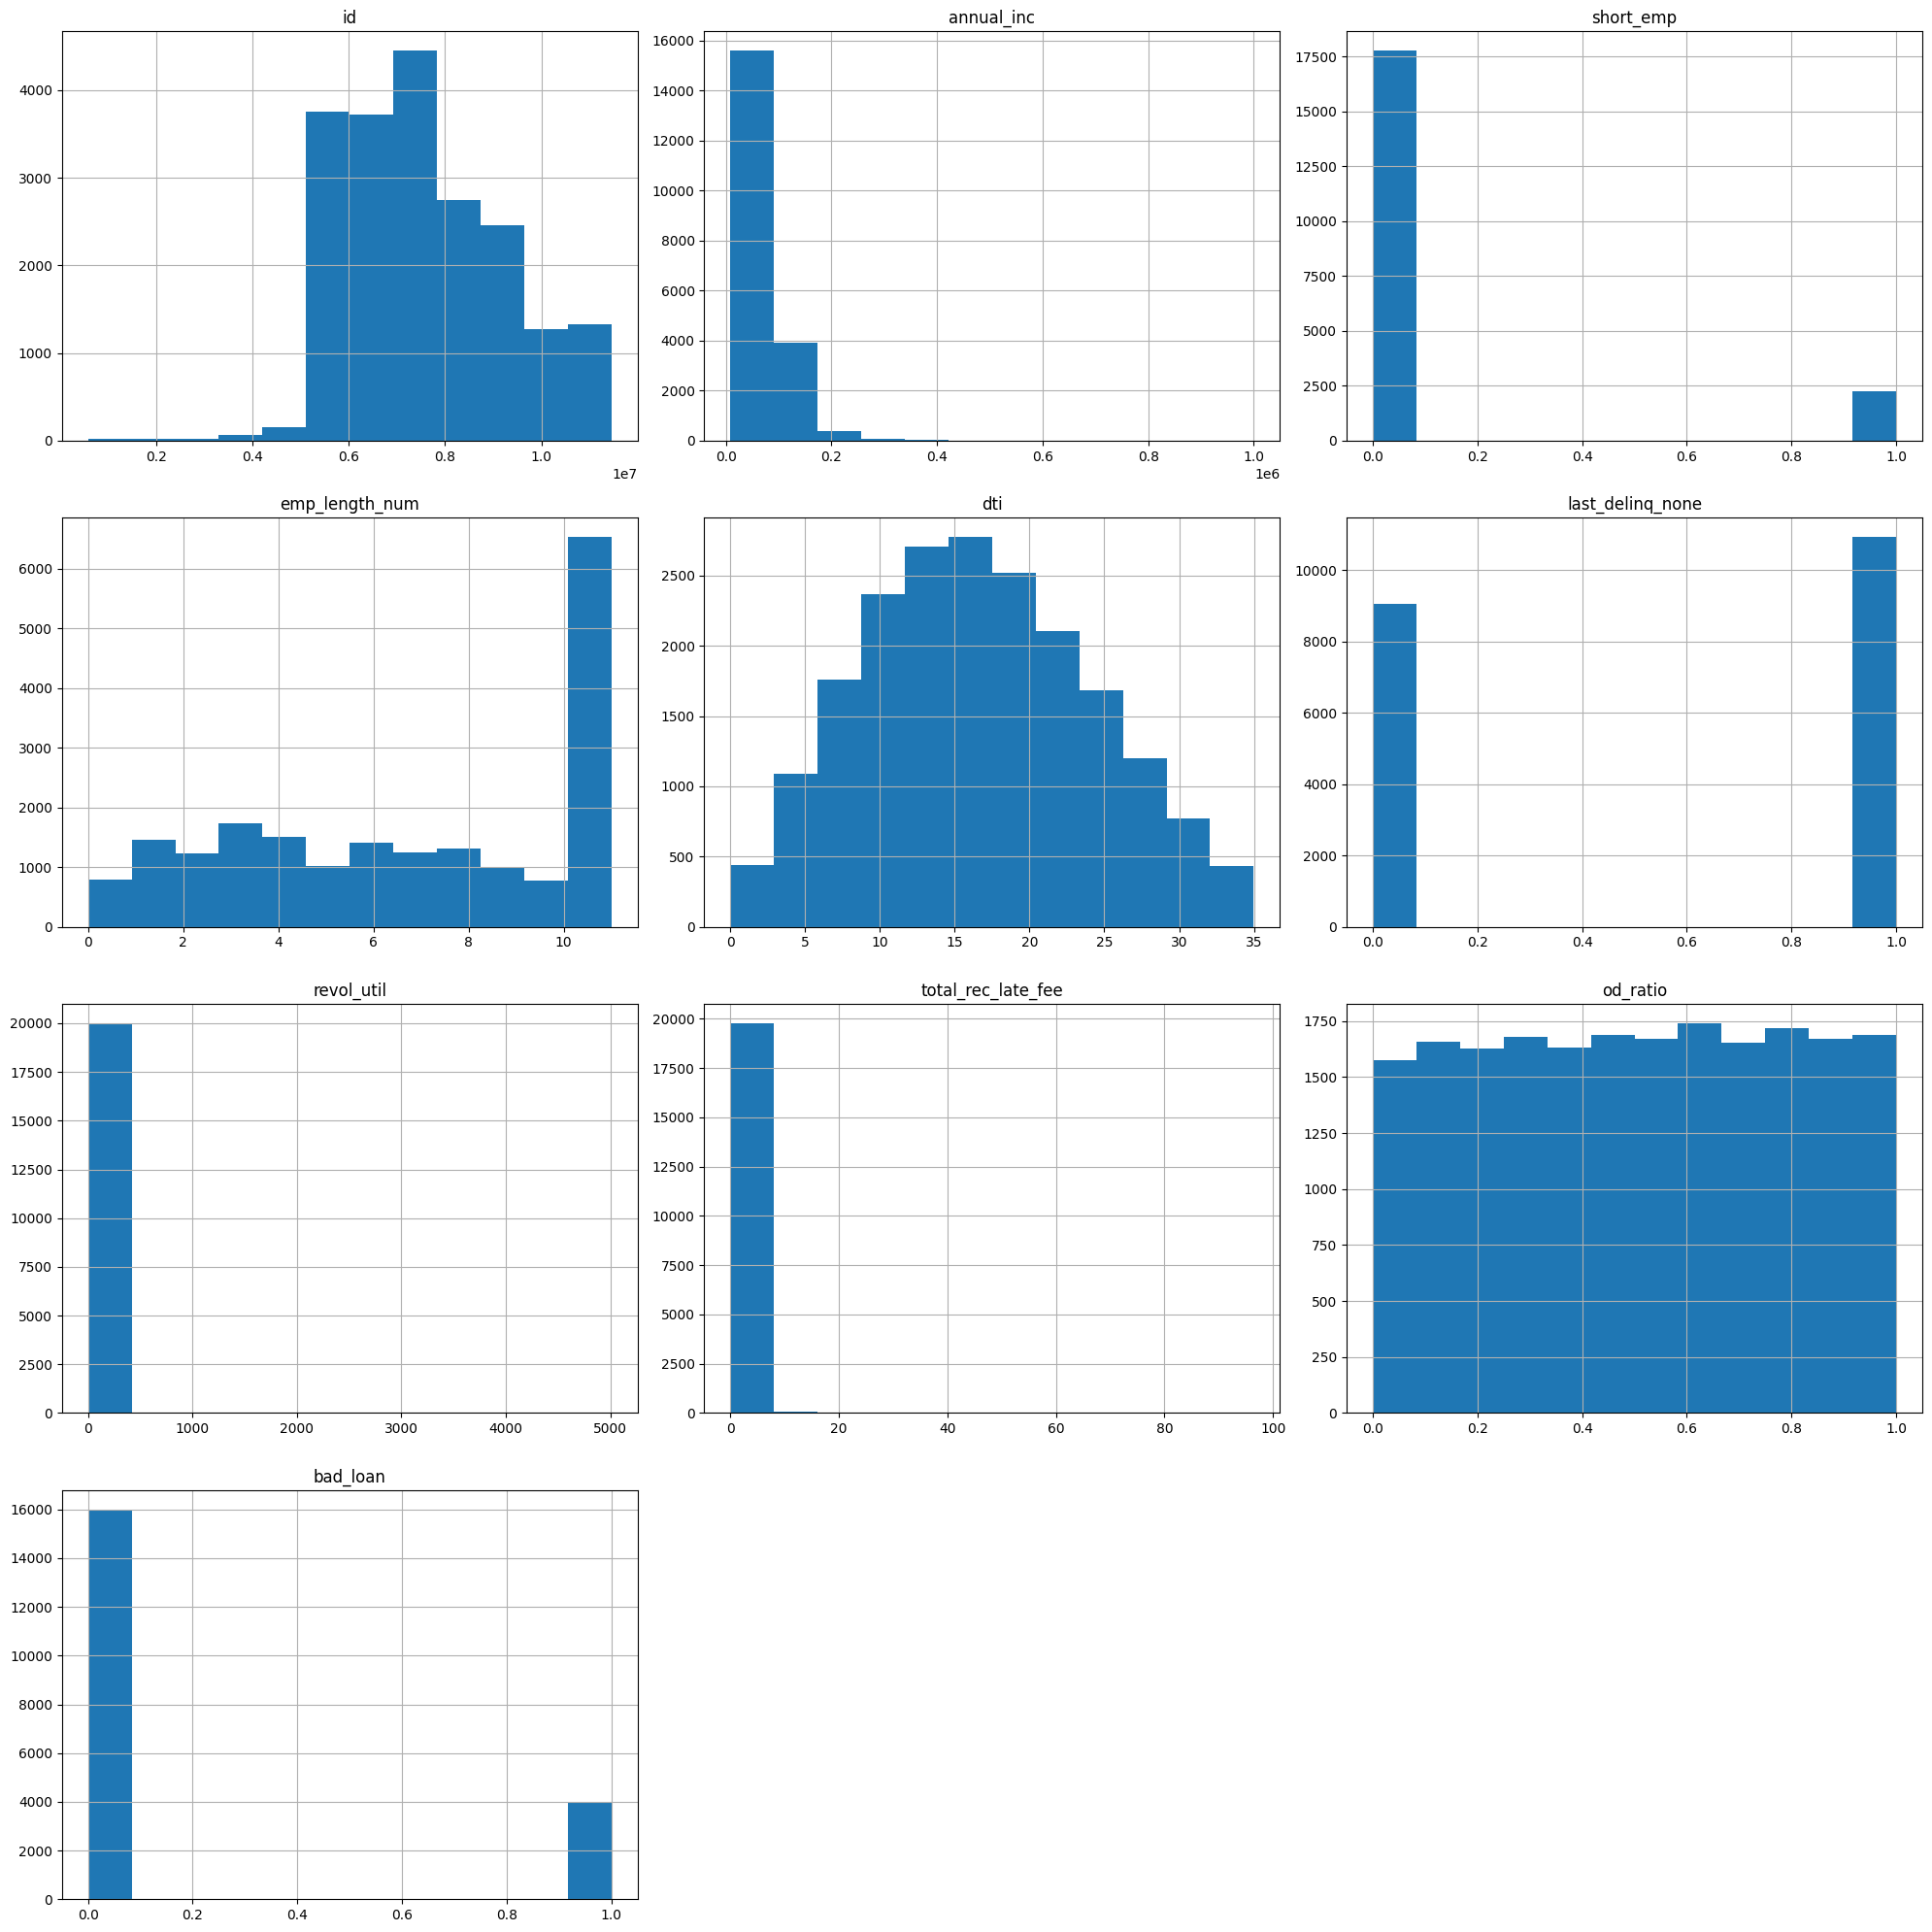

In [ ]:
data.hist(figsize = (20, 20), bins = 12)
plt.tight_layout()
plt.show()

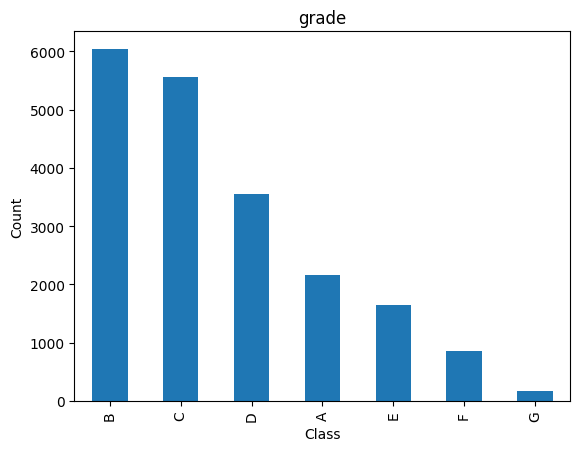

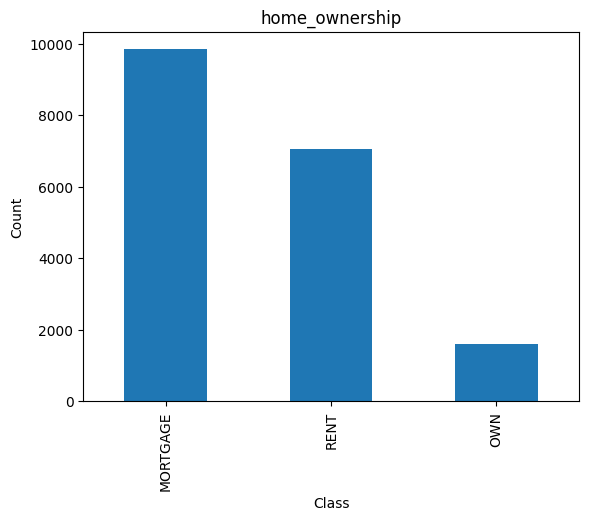

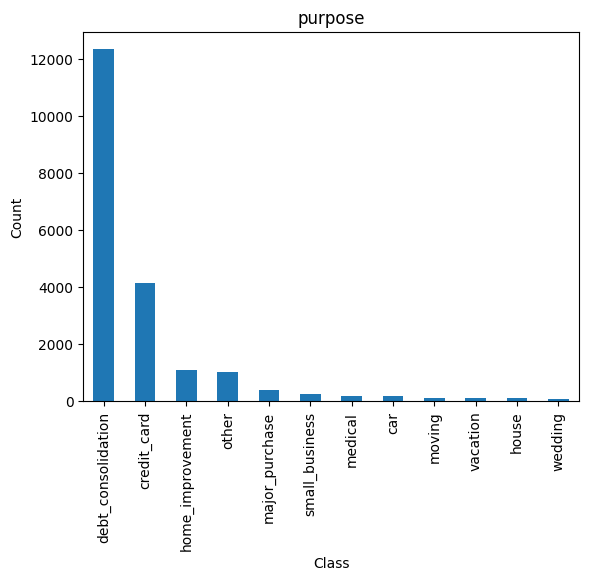

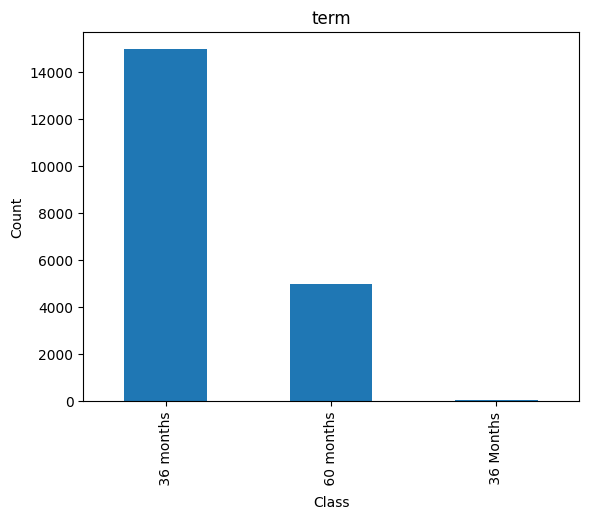

In [ ]:
for col in data.select_dtypes(include = ["object"]).columns:
  data[col].value_counts().plot(kind = "bar")
  plt.xlabel("Class")
  plt.ylabel("Count")
  plt.title(col)
  plt.show()

In [ ]:
data.term = data.term.str.lower()
data.term.value_counts()

,count
term,
36 months,15001
60 months,4999


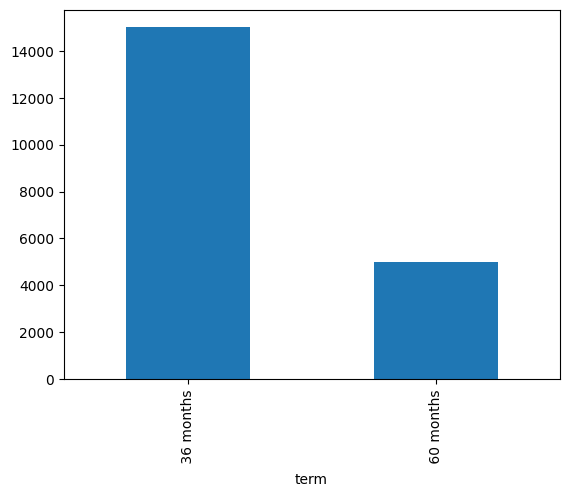

In [ ]:
data["term"].value_counts().plot(kind = 'bar')
plt.show()

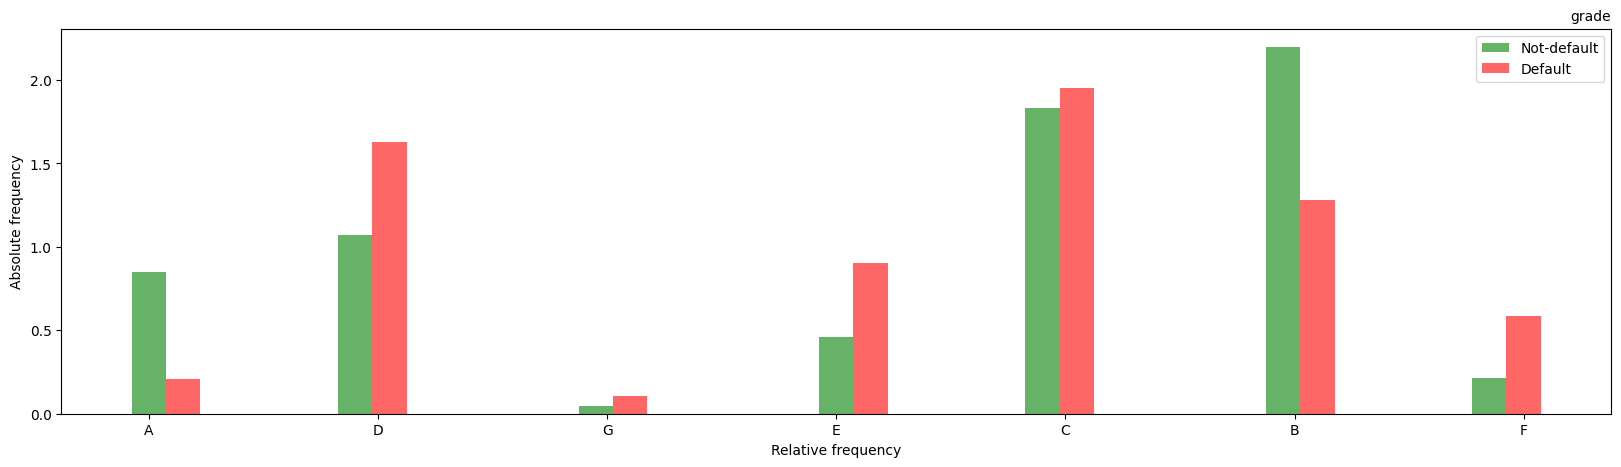

In [ ]:
target("grade")

<Axes: xlabel='annual_inc', ylabel='Density'>

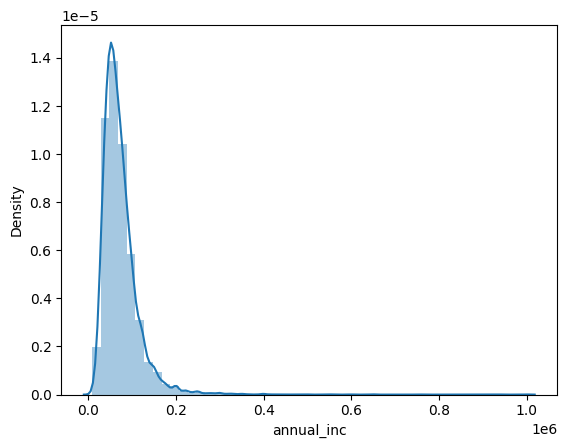

In [ ]:
sns.distplot(data['annual_inc'])

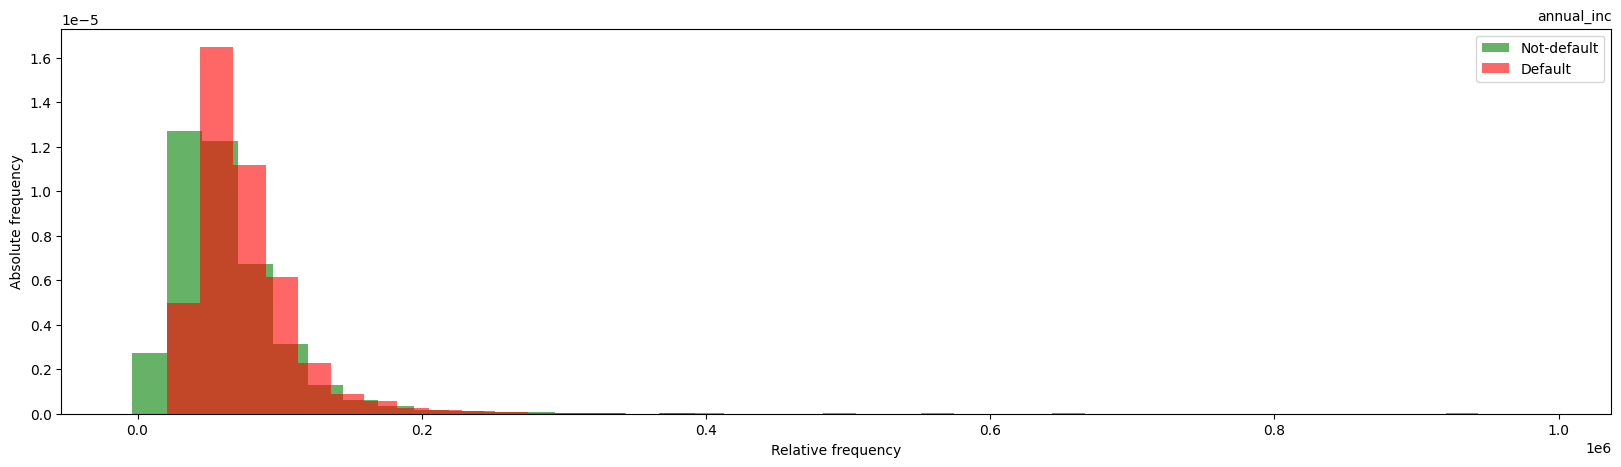

In [ ]:
target("annual_inc")

<Axes: xlabel='short_emp'>

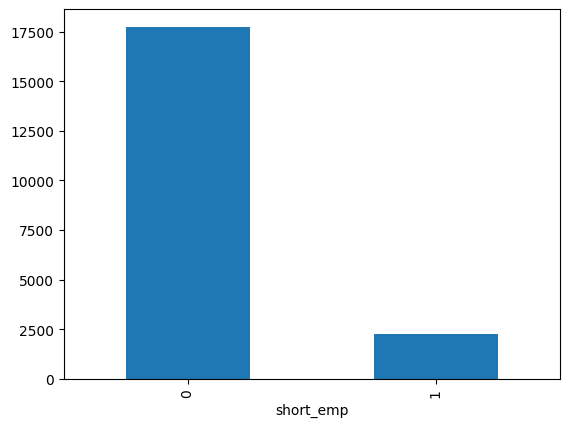

In [ ]:
data['short_emp'].value_counts().plot(kind = 'bar')

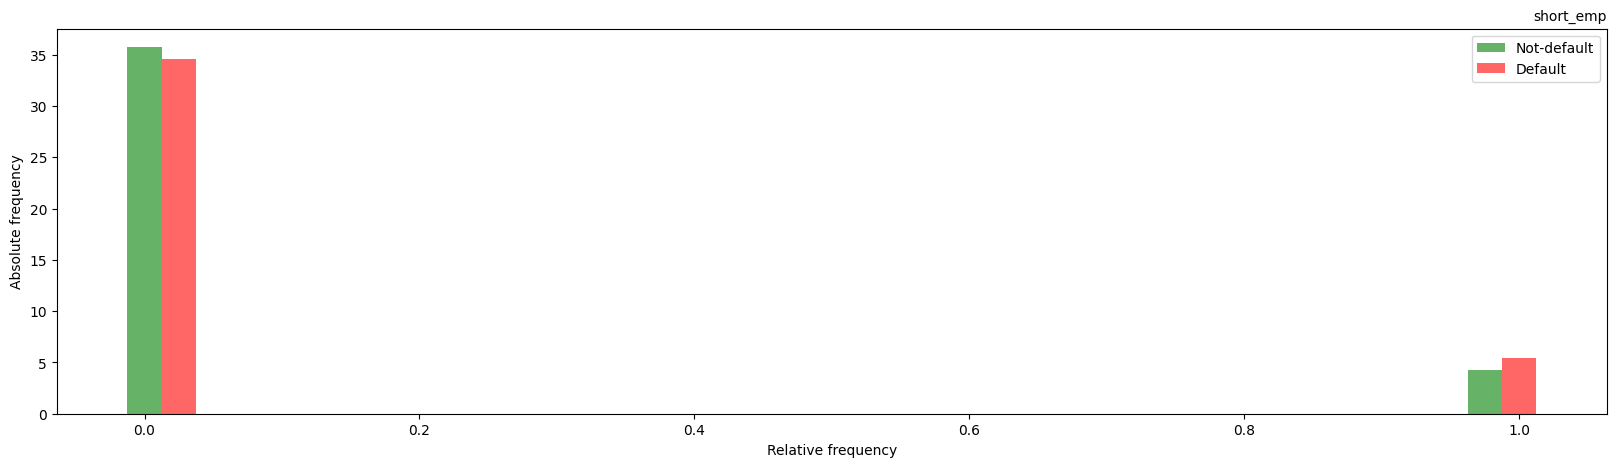

In [ ]:
target("short_emp")

<Axes: xlabel='emp_length_num', ylabel='Density'>

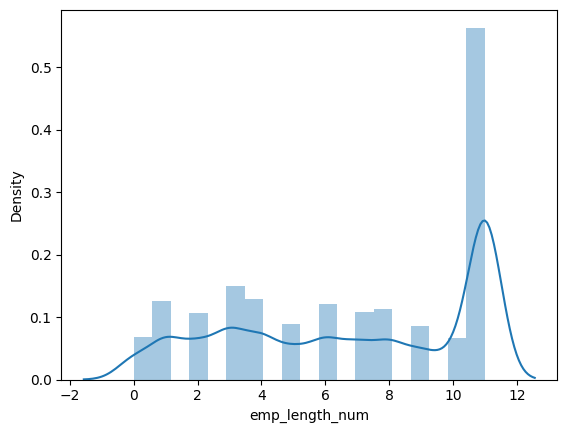

In [ ]:
sns.distplot(data['emp_length_num'])

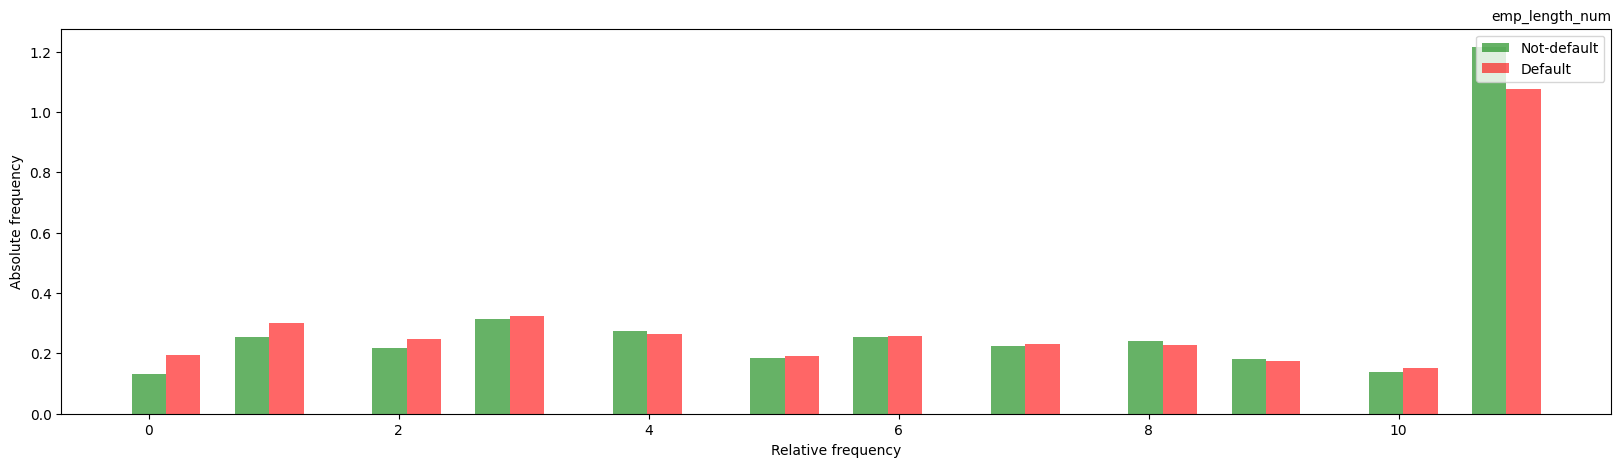

In [ ]:
target("emp_length_num")

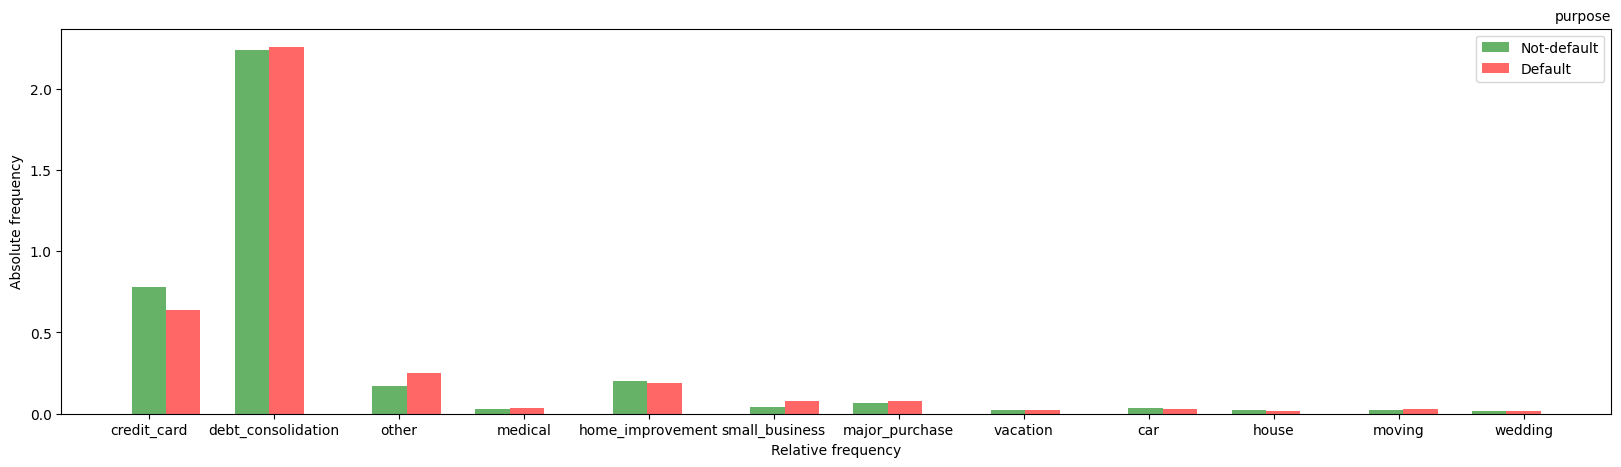

In [ ]:
target("purpose")

<Axes: xlabel='dti', ylabel='Density'>

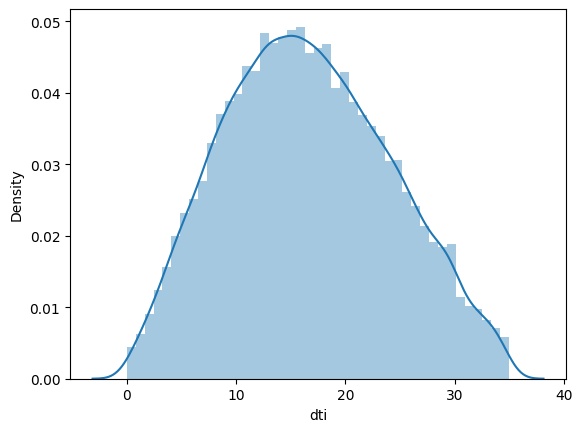

In [ ]:

sns.distplot(data['dti'])

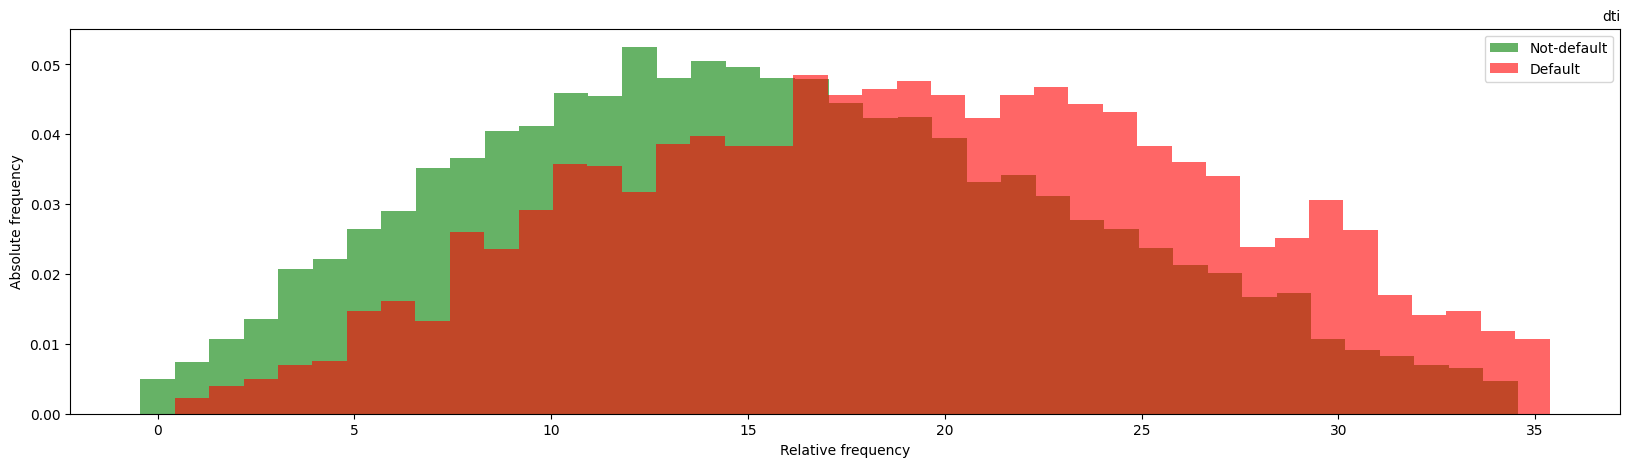

In [ ]:
target("dti")

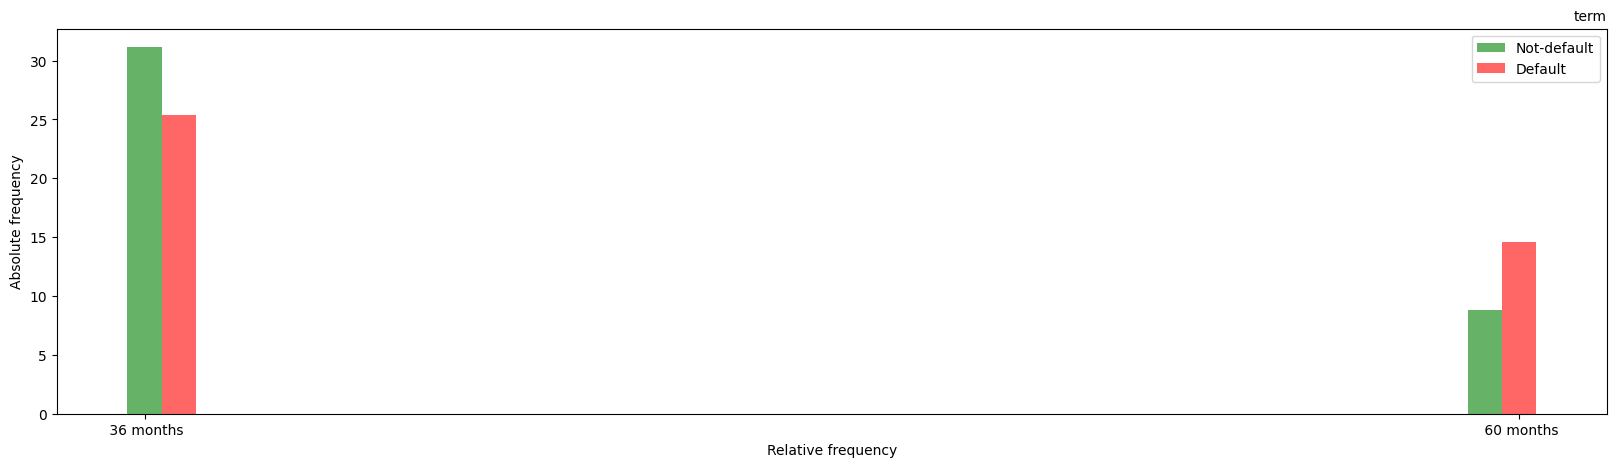

In [ ]:
target("term")

<Axes: xlabel='revol_util', ylabel='Density'>

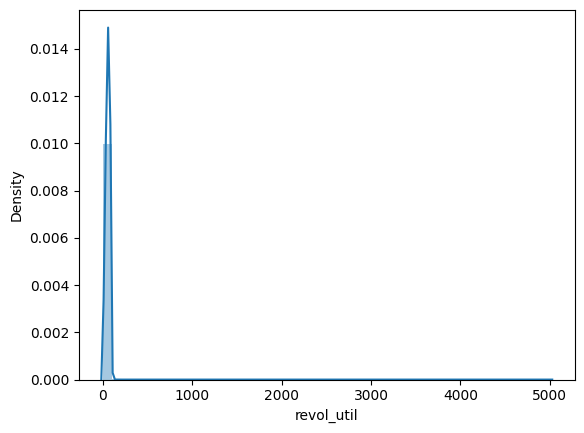

In [ ]:
sns.distplot(data["revol_util"])

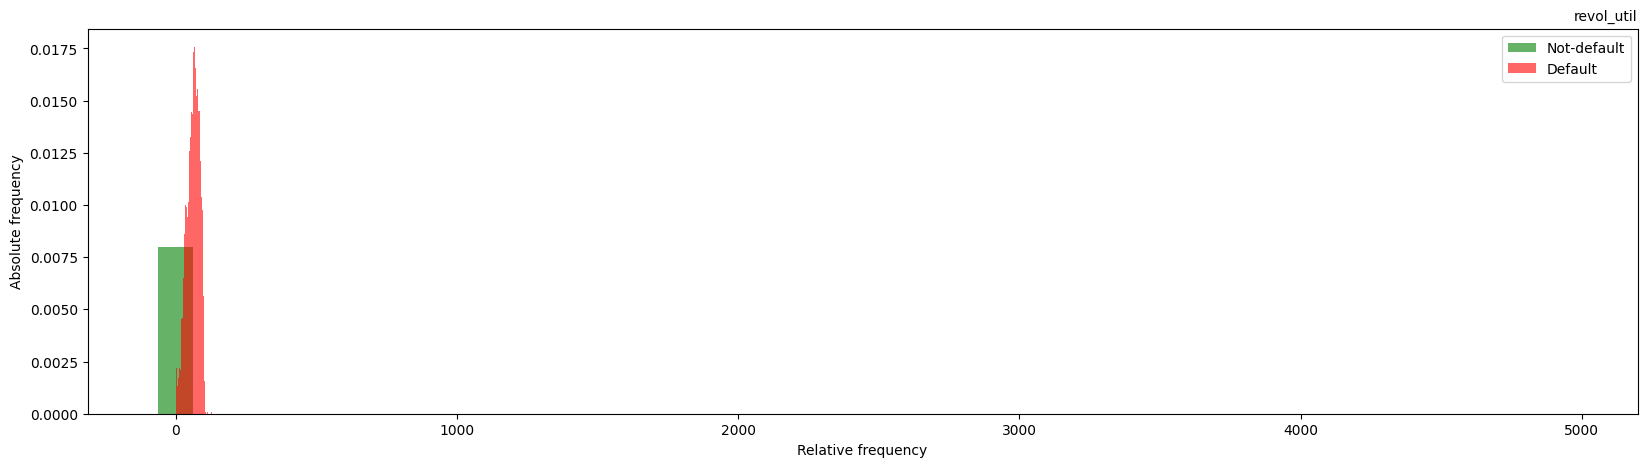

In [ ]:
target("revol_util")

<Axes: xlabel='total_rec_late_fee', ylabel='Density'>

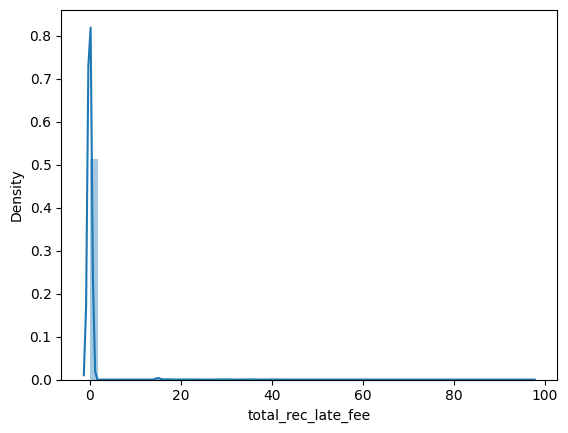

In [ ]:
sns.distplot(data["total_rec_late_fee"])

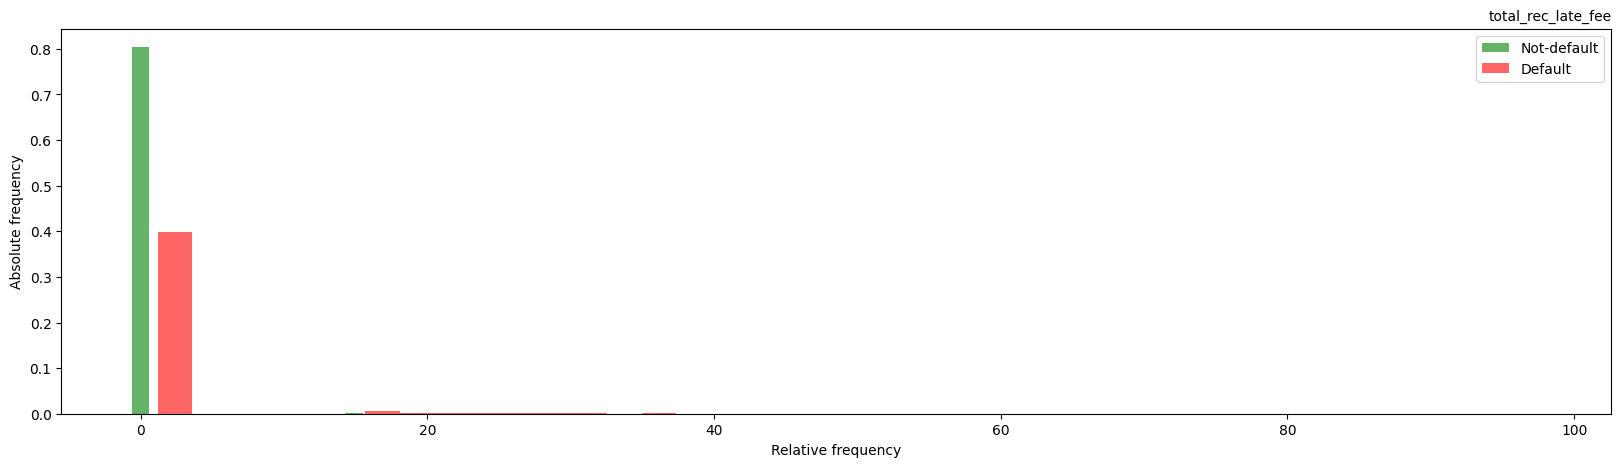

In [ ]:
target("total_rec_late_fee")

<Axes: xlabel='od_ratio', ylabel='Density'>

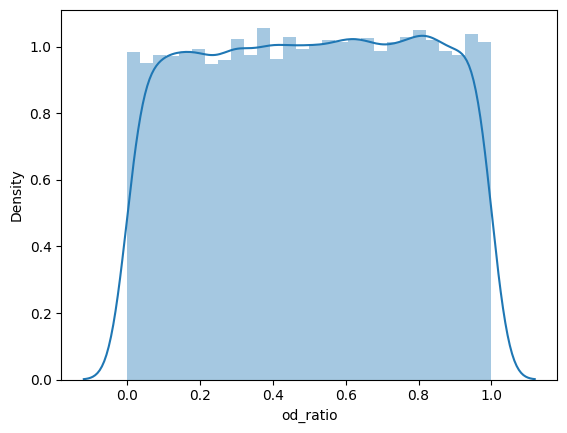

In [ ]:
sns.distplot(data["od_ratio"])

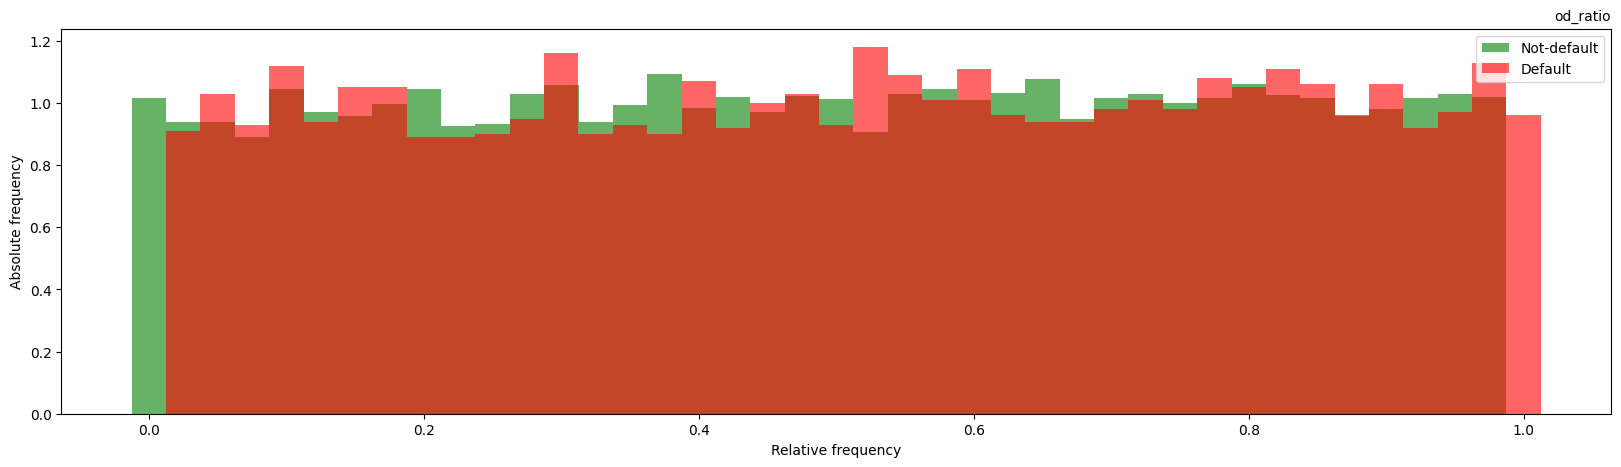

In [ ]:
target("od_ratio")

<Axes: xlabel='last_delinq_none'>

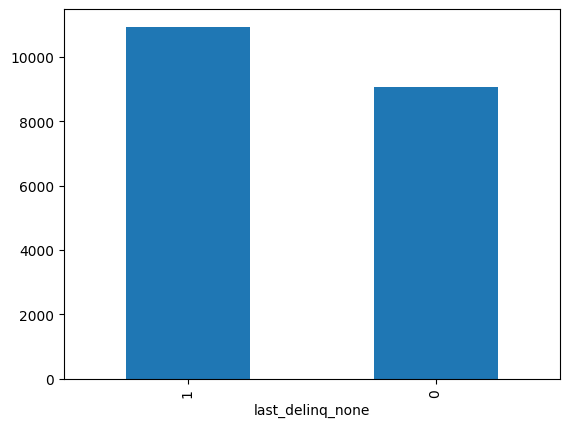

In [ ]:
data['last_delinq_none'].value_counts().plot(kind = 'bar')

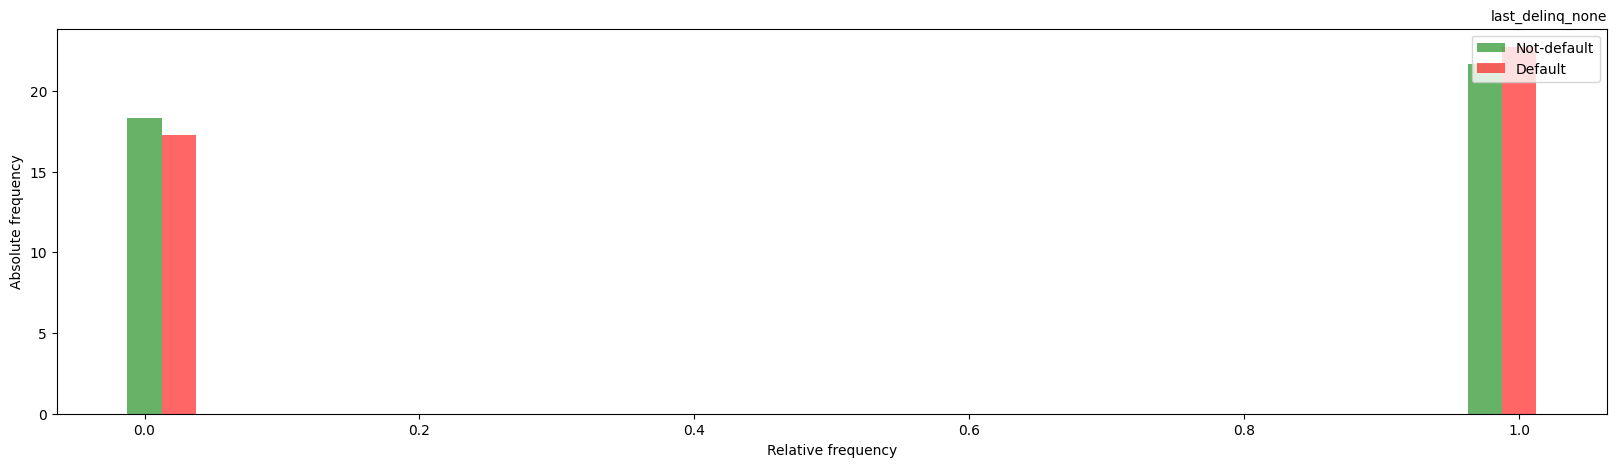

In [ ]:
target('last_delinq_none')

In [ ]:
print(data.dtypes)

id                      int64
grade                  object
annual_inc            float64
short_emp               int64
emp_length_num          int64
home_ownership         object
dti                   float64
purpose                object
term                   object
last_delinq_none        int64
revol_util            float64
total_rec_late_fee    float64
od_ratio              float64
bad_loan                int64
dtype: object


In [ ]:
data_numeric = data.select_dtypes(include=[np.number])

In [ ]:
print(data_numeric.dtypes)

id                      int64
annual_inc            float64
short_emp               int64
emp_length_num          int64
dti                   float64
last_delinq_none        int64
revol_util            float64
total_rec_late_fee    float64
od_ratio              float64
bad_loan                int64
dtype: object


<Axes: >

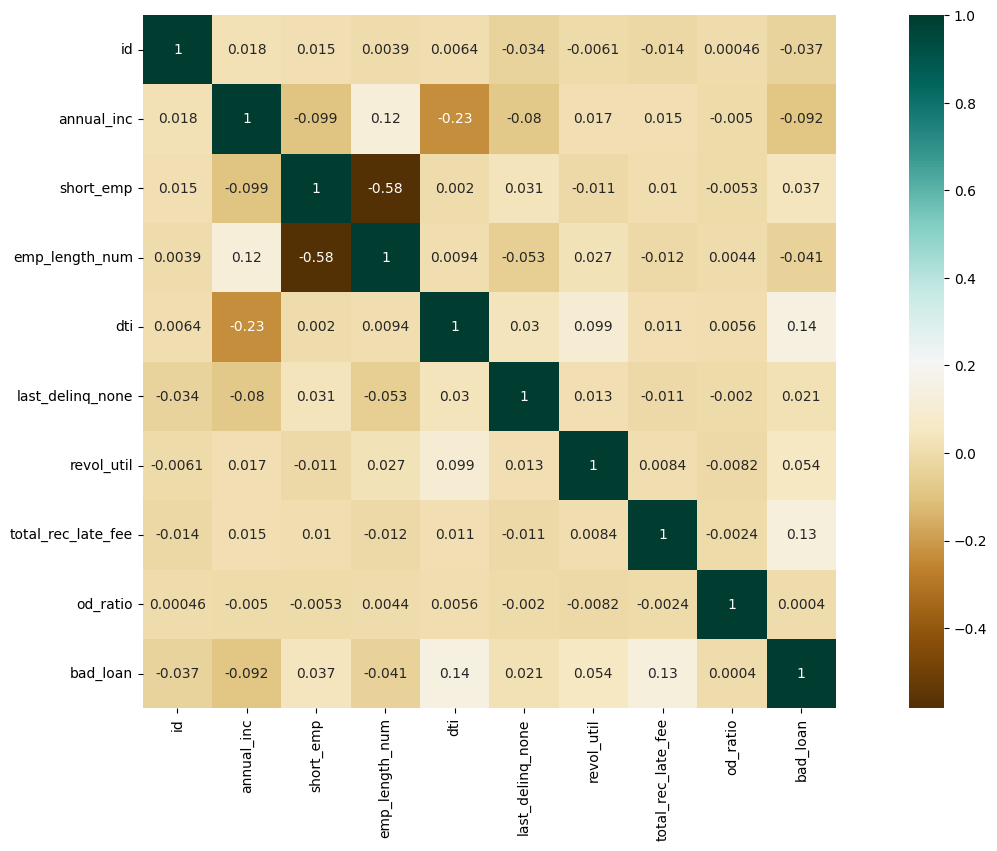

In [ ]:
mask = np.triu(data_numeric.corr(), 1)
plt.figure(figsize=(19, 9))
sns.heatmap(data_numeric.corr(), annot=True, square=True, cmap='BrBG')

In [ ]:
data_ca = data.select_dtypes(exclude=["int64","float64"]).copy()
data_nu = data.select_dtypes(exclude=["object","category"]).copy()

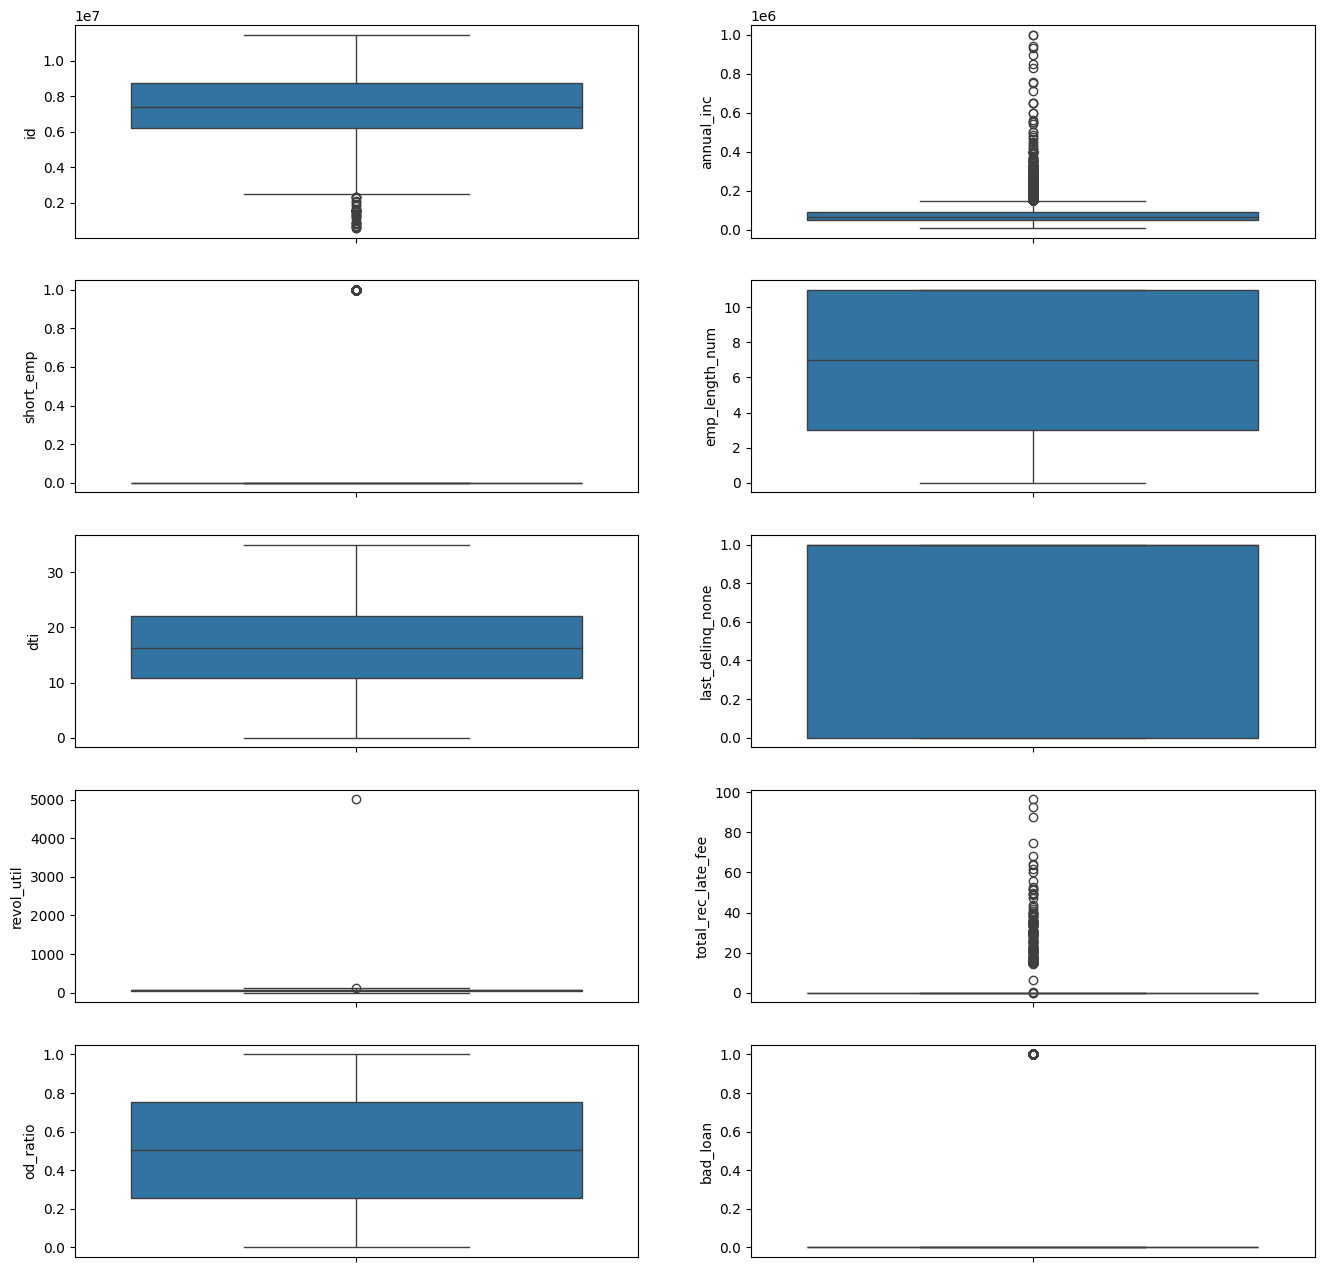

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(16, 16))
index = 0
axs = axs.flatten()
for k,v in data_nu.items():
    sns.boxplot(y=k, data=data_nu, ax=axs[index], orient="h")
    index += 1
    # plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [ ]:
# Dealing with the outliers through IQR score method
# Q1 = data['annual_inc'].quantile(0.25)
# Q3 = data['annual_inc'].quantile(0.75)
# IQR = Q3 - Q1
# data = data[((data['annual_inc'] > (Q1 - 1.5 * IQR)) &(data['annual_inc'] < (Q3 + 1.5 * IQR)))]

# value = data.revol_util.quantile([.99])
# p = value.iloc[0]
# data = data[data['annual_inc'] < p]

<Axes: ylabel='annual_inc'>

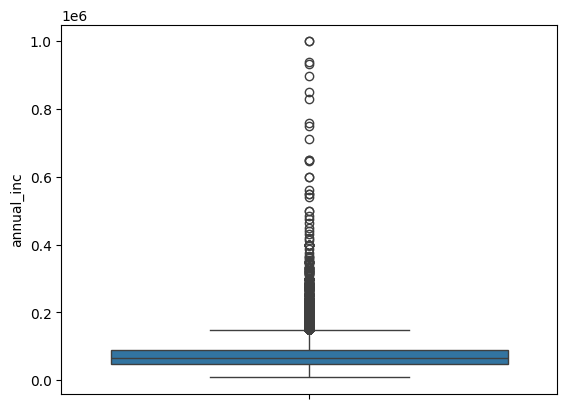

In [ ]:
sns.boxplot( data=data["annual_inc"])

In [ ]:
data.annual_inc.isnull().sum()

0

<Axes: ylabel='revol_util'>

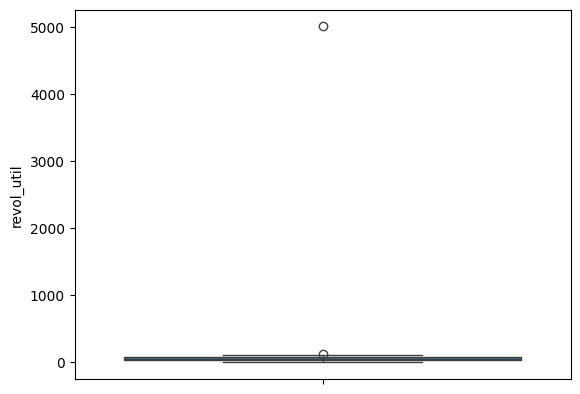

In [ ]:
sns.boxplot(data = data['revol_util'])

In [ ]:
Q1 = data['revol_util'].quantile(0.25)
Q3 = data['revol_util'].quantile(0.75)
IQR = Q3 - Q1
data = data[((data['revol_util'] > (Q1 - 1.5 * IQR)) &(data['revol_util'] < (Q3 + 1.5 * IQR)))]

In [ ]:
# value = data.revol_util.quantile([.99999])
# p = value.iloc[0]
# data = data[data["revol_util"] < 100]

<Axes: ylabel='revol_util'>

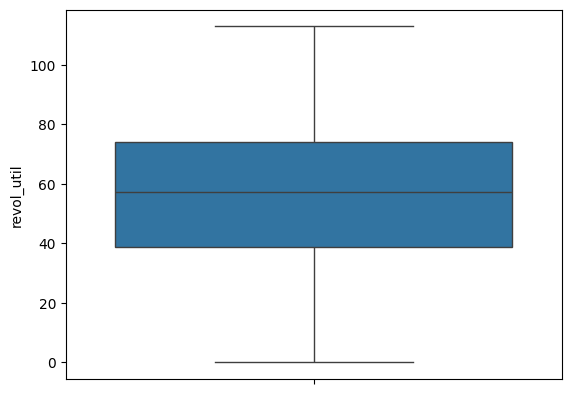

In [ ]:
sns.boxplot( data=data["revol_util"])

In [ ]:
value = data.total_rec_late_fee.quantile([.989])
p = value.iloc[0]
data = data[data["total_rec_late_fee"] < p]

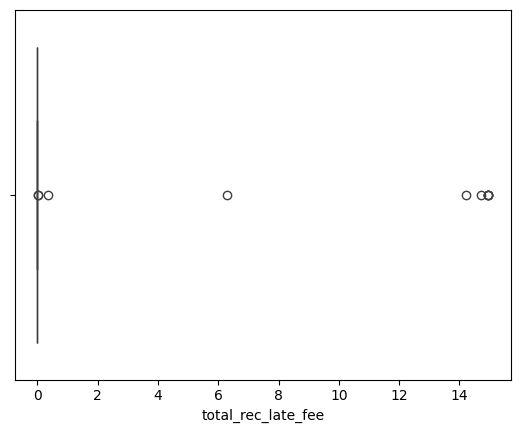

In [ ]:
sns.boxplot(x=data['total_rec_late_fee'],data=data)
plt.xlabel('total_rec_late_fee', fontsize=10)
plt.show()

In [ ]:
data["annual_inc"] = data.annual_inc.fillna(data.annual_inc.mean())

In [ ]:
data["home_ownership"] = data.home_ownership.fillna(data.home_ownership.value_counts().index[0])

In [ ]:
data["dti"] = data.dti.fillna(data.dti.mean())

In [ ]:
data.isnull().sum()


,0
id,0
grade,0
annual_inc,0
short_emp,0
emp_length_num,0
home_ownership,0
dti,0
purpose,0
term,0
last_delinq_none,0


In [ ]:
Xcat = data.select_dtypes(exclude=['int64','float64']).copy()
Xcat['target'] = data.bad_loan
Xcat.dropna(how="any", inplace=True)
ycat = Xcat.target
Xcat.drop("target", axis=1, inplace=True)
for col in Xcat.columns:
    table = pd.crosstab(Xcat[col], ycat)
    print()
    display(table)
    _, pval, _, expected_table = scipy.stats.chi2_contingency(table)
    print(f"p-value: {pval:.25f}")

target,0,1
grade,,
A,2030,120
B,5257,736
C,4375,1127
D,2565,947
E,1099,516
F,509,333
G,102,62


p-value: 0.0000000000000000000000000



target,0,1
home_ownership,,
MORTGAGE,9298,1922
OWN,1293,307
RENT,5346,1612


p-value: 0.0000000000000000000001839



target,0,1
purpose,,
car,138,30
credit_card,3424,679
debt_consolidation,9824,2386
home_improvement,881,199
house,85,12
major_purchase,289,83
medical,135,37
moving,92,28
other,744,261


p-value: 0.0000000000000802337614229



target,0,1
term,,
36 months,12415,2437
60 months,3522,1404


p-value: 0.0000000000000000000000000


In [ ]:
data.drop("id", axis=1, inplace=True)

In [ ]:
data["grade"] = data.grade.map({"A":7, "B":6, "C":5, "D":4, "E":3, "F":2, "G":1})

In [ ]:
data = pd.get_dummies(data, columns=["term","home_ownership", "purpose"])

In [ ]:
df = data

In [ ]:
df.columns = [x.lower() for x in df.columns]

In [ ]:
df.columns

Index(['grade', 'annual_inc', 'short_emp', 'emp_length_num', 'dti',
       'last_delinq_none', 'revol_util', 'total_rec_late_fee', 'od_ratio',
       'bad_loan', 'term_ 36 months', 'term_ 60 months',
       'home_ownership_mortgage', 'home_ownership_own', 'home_ownership_rent',
       'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_small_business', 'purpose_vacation', 'purpose_wedding'],
      dtype='object')

In [ ]:
df.dtypes

,0
grade,int64
annual_inc,float64
short_emp,int64
emp_length_num,int64
dti,float64
last_delinq_none,int64
revol_util,float64
total_rec_late_fee,float64
od_ratio,float64
bad_loan,int64


In [ ]:
df.shape

(19778, 27)

In [ ]:
df['bad_loan'].value_counts()

,count
bad_loan,
0,15937
1,3841


In [ ]:
df_train = df.copy()
from imblearn.over_sampling import SMOTE
# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Fit the model to generate the data.
oversampled_X, oversampled_Y = sm.fit_resample(df_train.drop('bad_loan', axis=1), df_train['bad_loan'])
oversampled = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

In [ ]:
oversampled.shape

(31874, 27)

In [ ]:
df_lr = oversampled.copy()
# Dividing the dataset in train (80%) and test (20%)
train_set_lr, test_set_lr = train_test_split(df_lr, test_size = 0.2, random_state = seed)
X_train_lr = train_set_lr.drop(['bad_loan'], axis = 1)
y_train_lr = train_set_lr['bad_loan']
X_test_lr = test_set_lr.drop(['bad_loan'], axis = 1)
y_test_lr = test_set_lr['bad_loan']
# Normalizing the train and test data
scaler_lr = MinMaxScaler()
features_names = X_train_lr.columns
X_train_lr = scaler_lr.fit_transform(X_train_lr)
X_train_lr = pd.DataFrame(X_train_lr, columns = features_names)
X_test_lr = scaler_lr.transform(X_test_lr)
X_test_lr = pd.DataFrame(X_test_lr, columns = features_names)


In [ ]:
lr=LogisticRegression(class_weight='balanced')
lr.fit(X_train_lr,y_train_lr)

LogisticRegression(class_weight='balanced')

In [ ]:
from sklearn.metrics import roc_auc_score,confusion_matrix,classification_report

In [ ]:
y_test_pred_lr=lr.predict(X_test_lr)

In [ ]:
print(classification_report(y_test_lr,y_test_pred_lr))

              precision    recall  f1-score   support

           0       0.77      0.96      0.86      3179
           1       0.95      0.72      0.82      3196

    accuracy                           0.84      6375
   macro avg       0.86      0.84      0.84      6375
weighted avg       0.86      0.84      0.84      6375



In [ ]:
print(f1_score(y_test_lr,y_test_pred_lr))

0.8183597224693114


In [ ]:
important_features = pd.DataFrame(data = abs(lr.coef_.T), index = X_train_lr.columns, columns = ["value"])
important_features.sort_values(by = "value", ascending = False)

,value
annual_inc,5.421622
home_ownership_rent,5.291676
term_ 60 months,5.202256
home_ownership_mortgage,5.114683
term_ 36 months,5.108178
home_ownership_own,4.819357
purpose_small_business,4.586147
purpose_debt_consolidation,4.533835
purpose_home_improvement,4.506013
purpose_major_purchase,4.497755


In [ ]:
from sklearn import metrics

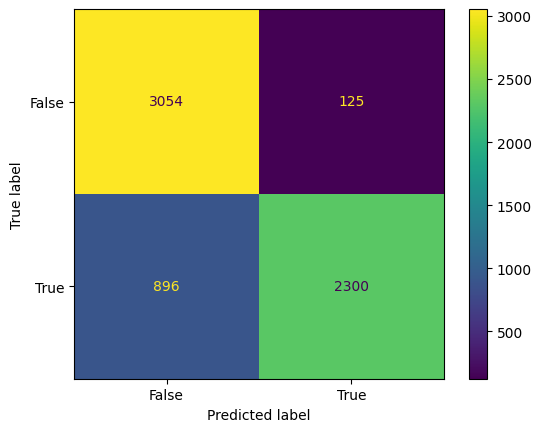

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test_lr, y_test_pred_lr)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [ ]:
from sklearn import svm
df_svm = oversampled.copy()
train_set_svc, test_set_svc = train_test_split(df_svm, test_size = 0.2, random_state = seed)
X_train_svc = train_set_svc.drop(['bad_loan'], axis = 1)
y_train_svc = train_set_svc['bad_loan']
X_test_svc = test_set_svc.drop(['bad_loan'], axis = 1)
y_test_svc = test_set_svc['bad_loan']
zscore_svc = StandardScaler()
features_names = X_train_svc.columns
X_train_svc = zscore_svc.fit_transform(X_train_svc)
X_train_svc = pd.DataFrame(X_train_svc, columns = features_names)
X_test_svc = zscore_svc.transform(X_test_svc)
X_test_svc = pd.DataFrame(X_test_svc, columns = features_names)

svc = SVC( class_weight='balanced')

In [ ]:
svc.fit(X_train_svc,y_train_svc)
y_test_pred_clf=svc.predict(X_test_svc)
print(classification_report(y_test_svc,y_test_pred_clf))

              precision    recall  f1-score   support

           0       0.76      0.99      0.86      3179
           1       0.98      0.70      0.81      3196

    accuracy                           0.84      6375
   macro avg       0.87      0.84      0.84      6375
weighted avg       0.87      0.84      0.84      6375



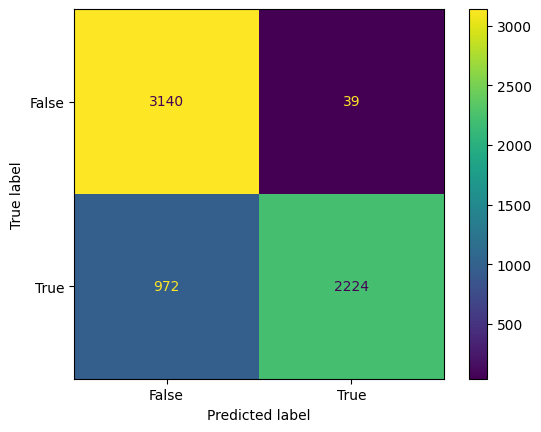

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test_svc, y_test_pred_clf)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [ ]:
print(f1_score(y_test_svc, y_test_pred_clf))

0.8148012456493864


In [ ]:
df_trees = oversampled.copy()
train_set_dt, test_set_dt = train_test_split(df_trees, test_size = 0.2, random_state = seed)
X_train_dt = train_set_dt.drop(['bad_loan'], axis = 1)
y_train_dt = train_set_dt['bad_loan']
X_test_dt = test_set_dt.drop(['bad_loan'], axis = 1)
y_test_dt = test_set_dt['bad_loan']
clf_tree = tree.DecisionTreeClassifier( max_depth = 10).fit(X_train_dt, y_train_dt)
y_test_pred_dt=clf_tree.predict(X_test_dt)
print(classification_report(y_test_dt, y_test_pred_dt))

              precision    recall  f1-score   support

           0       0.77      0.87      0.82      3179
           1       0.85      0.75      0.80      3196

    accuracy                           0.81      6375
   macro avg       0.81      0.81      0.81      6375
weighted avg       0.81      0.81      0.81      6375



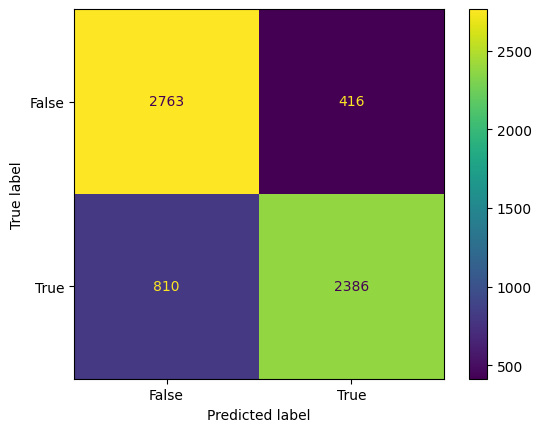

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test_dt, y_test_pred_dt)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [ ]:
print(f1_score(y_test_dt, y_test_pred_dt))

0.7955985328442815


In [ ]:
df_rf = oversampled.copy()
train_set_rf, test_set_rf = train_test_split(df_rf, test_size = 0.2, random_state = seed)
X_train_rf = train_set_rf.drop(['bad_loan'], axis = 1)
y_train_rf = train_set_rf['bad_loan']
X_test_rf = test_set_rf.drop(['bad_loan'], axis = 1)
y_test_rf = test_set_rf['bad_loan']
rf = RandomForestClassifier(n_estimators = 100,  class_weight = None).fit(X_train_rf, y_train_rf)
y_test_pred_rf=rf.predict(X_test_rf)
print(classification_report(y_test_rf, y_test_pred_rf))


              precision    recall  f1-score   support

           0       0.82      0.93      0.87      3179
           1       0.92      0.79      0.85      3196

    accuracy                           0.86      6375
   macro avg       0.87      0.86      0.86      6375
weighted avg       0.87      0.86      0.86      6375



In [ ]:
y_train_pred_rf=rf.predict(X_train_rf)
print(classification_report(y_train_rf, y_train_pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12758
           1       1.00      1.00      1.00     12741

    accuracy                           1.00     25499
   macro avg       1.00      1.00      1.00     25499
weighted avg       1.00      1.00      1.00     25499



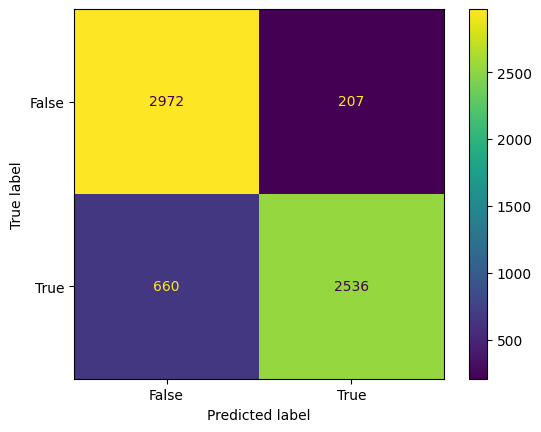

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test_rf, y_test_pred_rf)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [ ]:
print(f1_score(y_test_rf, y_test_pred_rf))

0.8540158275804008


In [ ]:
rf = RandomForestClassifier(random_state = seed, class_weight = None).fit(X_train_rf, y_train_rf)
parameters = {'n_estimators':[10, 100, 300, 1000], 'min_samples_split' : [2, 5, 10], 'min_samples_leaf' :[1, 2, 4]}
clf_rf = RandomizedSearchCV(rf, parameters, cv = 5).fit(X_train_rf, y_train_rf)
y_test_pred_rf=rf.predict(X_test_rf)
print(f1_score(y_test_rf, y_test_pred_rf))

0.8534322820037106


### Random Forest gave the best result with F1 score **0.85**